In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [155]:
sr = pd.read_csv("data/2017_all.csv")
schools = pd.read_csv("data/entities.csv")
#zips = pd.read_csv("data/zip_code_database.csv")

In [156]:
sanctuaries  = {'Alameda','Contra Costa','Los Angeles','Monterey','Napa','Riverside','Sacramento','San Bernardino','San Diego','San Francisco','San Mateo','Santa Clara','Santa Cruz','Sonoma'
}


our data frame sr,School Record, now contains contains all the information about student scores and populations. Our issue is that it also contains information about a number of other student groups we are not interested in, like disability status. the next issue we will want to deal with are the asterisks rows. from reading the survey methodology, we know these represent an ommitted score. scores are ommitted if they represent the average of fewer than 10 students. this concerns us because it means we dont have data for classes that contain fewer than 10 migrant students. there is an option to group students by school and not by grade will give us more schools with non-ommitted information for the migrant students. each of these entries has a school code we will join with the enties list that contains school and zip codes.

In [157]:
#we remove any empty data as well as data for district summary. only non zero school codes map to actual schools.
mask = sr['Area 1 Percentage Below Standard'] != '*'
sr = sr[mask]
mask = sr['School Code'] > 0
sr = sr[mask]
sr['Mean Scale Score'] = pd.to_numeric(sr['Mean Scale Score'])
sr.shape

(1434757, 32)

In [158]:
#Selecting only the math scores to minimize language bias
mask = sr['Test Type']=='B'
sr = sr[mask]
mask = sr['Test Id'] == 2
#selecting the pool of all students at each school
mask = sr['Grade'] == 3
sr = sr[mask]

In [159]:
#we will now segemnt to get two list of schools with the scores for the total and migrant population
all_mask = sr['Subgroup ID'] == 1
migrant_mask = sr['Subgroup ID'] == 28
school_all = sr[all_mask]
school_migrant = sr[migrant_mask]
school_all.iloc[3]

County Code                               1
District Code                         10017
School Code                          124172
Filler                                  NaN
Test Year                              2017
Subgroup ID                               1
Test Type                                 B
Total Tested At Entity Level            178
Total Tested with Scores                177
Grade                                     3
Test Id                                   1
CAASPP Reported Enrollment               52
Students Tested                          50
Mean Scale Score                     2500.1
Percentage Standard Exceeded          54.00
Percentage Standard Met               24.00
Percentage Standard Met and Above     78.00
Percentage Standard Nearly Met         8.00
Percentage Standard Not Met           14.00
Students with Scores                     50
Area 1 Percentage Above Standard      54.00
Area 1 Percentage Near Standard       32.00
Area 1 Percentage Below Standard

In [160]:
school_all_scores = school_all[['School Code','Mean Scale Score']]
school_migrant_scores = school_migrant[['School Code','Mean Scale Score']]
school_all_scores = school_all_scores.rename(index=str, columns={"Mean Scale Score":"all score"})
school_migrant_scores = school_migrant_scores.rename(index=str, columns={"Mean Scale Score":"migrant score"})
print(np.mean(school_migrant_scores['migrant score']))

2378.4005780346806


In [161]:
#now we will join the two data frames using school code as the index
print(school_migrant_scores.shape)
school_all_scores = school_all_scores.drop_duplicates('School Code')
school_list = school_migrant_scores.merge(school_all_scores[['School Code','all score']],how='left',on='School Code')
print(school_list.shape)
#school_list

(173, 2)
(173, 3)


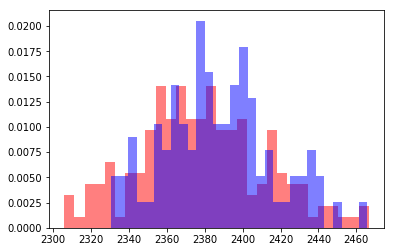

In [162]:
_ = plt.hist(school_list['migrant score'],bins = 30,color ='red',alpha=.5,normed =True)
_ = plt.hist(school_list['all score'],bins =30,color = 'blue',alpha = .5,normed = True)
plt.show()
#all ready I think we can see the difference in distrobutions of the migrant and general population

In [163]:
school_list = school_list.merge(schools,how='left',on='School Code')
school_list = school_list.rename(index=str, columns={"Zip Code_x": "zip"})
school_list.iloc[3]
#this gives location and district information for our schools
#we will be using this to test for sanctuary status

School Code                    6007256
migrant score                   2381.3
all score                       2413.1
County Code                         10
District Code                    62430
Filler                             NaN
Test Year                         2017
Type Id                              7
County Name                     Fresno
District Name            Selma Unified
School Name      Eric White Elementary
Zip Code                         93662
Name: 3, dtype: object

In [164]:
#now we have each school with its zip code, total and migrant scores we will merge data about santuary counties
#zips.head()

In [165]:
#ca_zips = zips[zips['state']=='CA']
#school_list = school_list.merge(ca_zips[['county','zip','latitude','longitude']],on='zip',how='left')
#school_list.iloc[3]

In [166]:
#now we update this new sanctuary column based on whether the county is in our sanctuary list
school_list['sanctuary'] = np.empty(len(school_list))
for i in range(len(school_list)):
   # school_list['Filler'][1] = 1
    if school_list.ix[i,'County Name'] in sanctuaries:
        school_list.ix[i,'sanctuary'] = 1
    else:
        school_list.ix[i,'sanctuary'] = 0
    #print(school_list.ix[i,'sanctuary'])
school_list.head(20)

/Users/nathanlaird/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


,School Code,migrant score,all score,County Code,District Code,Filler,Test Year,Type Id,County Name,District Name,School Name,Zip Code,sanctuary
0,6104566,2372.6,2388.1,1,61192,NaN,2017,7,Alameda,Hayward Unified,Tyrrell Elementary,94540,1.0
1,6104566,2408.2,2388.1,1,61192,NaN,2017,7,Alameda,Hayward Unified,Tyrrell Elementary,94540,1.0
2,6007256,2410.2,2413.1,10,62430,NaN,2017,7,Fresno,Selma Unified,Eric White Elementary,93662,0.0
3,6007256,2381.3,2413.1,10,62430,NaN,2017,7,Fresno,Selma Unified,Eric White Elementary,93662,0.0
4,6005995,2454.2,2430.9,10,73809,NaN,2017,7,Fresno,Firebaugh-Las Deltas Unified,Arthur E. Mills Intermediate,93622,0.0
5,6005995,2466.5,2430.9,10,73809,NaN,2017,7,Fresno,Firebaugh-Las Deltas Unified,Arthur E. Mills Intermediate,93622,0.0
6,6006969,2354.3,2400.5,10,75127,NaN,2017,7,Fresno,Mendota Unified,Mccabe Elementary,93640,0.0
7,6006969,2368.8,2400.5,10,75127,NaN,2017,7,Fresno,Mendota Unified,Mccabe Elementary,93640,0.0
8,6005813,2436.3,2410.2,10,75598,NaN,2017,7,Fresno,Caruthers Unified,Caruthers Elementary,93609,0.0
9,6005813,2377.9,2410.2,10,75598,NaN,2017,7,Fresno,Caruthers Unified,Caruthers Elementary,93609,0.0


Fantastic, our data data now contains over 130 school with data about how migrant students perfrom relative to the general population and reference as to whether they are in a Sanctuary County.

In [167]:
school_list.to_csv('data/third_math_AB.csv')

Important things to note about our data

This data does not include the scores of every student in california. Due to privacy concerns I can not access information about scores for groups of fewer than 10 students. This means that our data does not include data for schools with fewer than 10 migrant students per grade level. 
